## Image classification with CNN

### Cats vs Dogs

Here we deal with the Kaggle Cats vs Dogs competition https://www.kaggle.com/c/dogs-vs-cats

Aim is to build a classifier to detect cats and dogs using PyTorch.

#### Things to learn:

* Transfer learning
* Using pre trained weights (done)
* Freezing layers and training a subset
* Precomputing activation functions to speed up training
* Saving and restoring models on filesystem
* Adaptive learning rate


#### References

* https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb
* https://github.com/pytorch/examples/blob/master/imagenet/main.py
* http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* https://github.com/Spandan-Madan/Pytorch_fine_tuning_Tutorial

### Import required libraries

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# PyTorch stuff
import torch
import torch.nn as nn
import torch.autograd as autograd
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

# TorchVision stuff
import torchvision.models as models

# Other stuff
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

# Custom stuff
import utility

%matplotlib inline

### Get the dataset

Download the dataset from http://files.fast.ai/data/dogscats.zip and update the 'data_path' below to point to the unzipped location.

In [3]:
data_path = "/home/as/datasets/fastai.dogscats"

### Some constants

In [4]:
img_size = 224                    # The height and width size we will use for this exercise
num_workers = 4                   # For DataLoader
checkpoint_folder = 'checkpoints' # Folder where all checkpoint weights are to be stored

In [5]:
# Create the checkpoint folder if not exists
if not os.path.exists(checkpoint_folder):
    os.mkdir(checkpoint_folder)

### Explore dataset

In [6]:
!ls {data_path}/

models	sample	test  test1  train  valid


In [7]:
train_files = !ls {data_path}/train/cats

In [8]:
train_files[:9]

['cat.0.jpg',
 'cat.10000.jpg',
 'cat.10001.jpg',
 'cat.10002.jpg',
 'cat.10003.jpg',
 'cat.10004.jpg',
 'cat.10005.jpg',
 'cat.10006.jpg',
 'cat.10007.jpg']

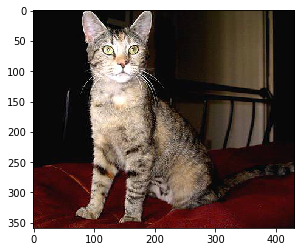

In [9]:
img = plt.imread(f'{data_path}/train/cats/{train_files[1]}')
plt.imshow(img)

In [10]:
img.shape # Not in good shape, we need to convert it to a standard size

(359, 431, 3)

In [11]:
# Let's find the average height and width of the training images
# This is going to take a while to run, so turn it to True if you want to see the stats

if False:
    height = 0
    width = 0

    for i in range(len(train_files)):
        path =  data_path + '/train/cats/' + train_files[i]
        img = plt.imread(path)
        height += img.shape[0]
        width += img.shape[1]

    print(height/len(train_files), width/len(train_files))

### Prepare the data loaders

We will use the ImageFolder class to fetch our data. It can dynamically load hugh datasets by reading them on the fly.

Explore ImageFolder here: https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py

**Transformers**

Let's create the transforms that we intend to apply to our images. Let's try two of them:

* One is vanilla
* Other is with data augmentation

In [12]:
# These should match the values used for the model we choose (we are choosing resnet34 here)
normaliser = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# This is a vanilla transformation
trans = transforms.Compose([transforms.Scale((img_size, img_size)), 
                            transforms.ToTensor(),
                            normaliser])

# This is a augmented transformation
trans_augmented = transforms.Compose([transforms.Scale((img_size, img_size)), 
                                      transforms.RandomHorizontalFlip(),
                                      # Add some more here
                                      transforms.ToTensor(),
                                      normaliser]) 

# Transformation for Validation and Test set
trans_validation = transforms.Compose([transforms.Scale((img_size, img_size)), 
                                      transforms.ToTensor(),
                                      normaliser]) 

** Datasets **

In [13]:
from torchvision.datasets.folder import ImageFolder

# Vanilla dataset
train_images = ImageFolder(f'{data_path}/train', transform=trans)

# Augmented dataset
train_images_augmented = ImageFolder(f'{data_path}/train', transform=trans_augmented)

# For valid and test datasets
valid_images = ImageFolder(f'{data_path}/valid', transform=trans_validation)

In [14]:
print(train_images.classes)
print(train_images.class_to_idx)
train_images.imgs[:3]

['cats', 'dogs']
{'cats': 0, 'dogs': 1}


[('/home/as/datasets/fastai.dogscats/train/cats/cat.0.jpg', 0),
 ('/home/as/datasets/fastai.dogscats/train/cats/cat.1.jpg', 0),
 ('/home/as/datasets/fastai.dogscats/train/cats/cat.10.jpg', 0)]

**DataLoader**s

Ok, now that we have our datasets defined, the following creates dataloaders based on the batch size passed. We want to try with different batch sizes.

In [15]:
def get_loaders(batch_size):
    train_image_loader = torch.utils.data.DataLoader(train_images, 
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     num_workers=num_workers, 
                                                     pin_memory=True) # For speedup, not always guaranteed

    train_image_aug_loader = torch.utils.data.DataLoader(train_images_augmented, 
                                                         batch_size=batch_size, 
                                                         shuffle=True, 
                                                         num_workers=num_workers, 
                                                         pin_memory=True) # For speedup, not always guaranteed

    valid_image_loader = torch.utils.data.DataLoader(valid_images, 
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     num_workers=num_workers, 
                                                     pin_memory=True) # For speedup, not always guaranteed

    return train_image_loader, valid_image_loader, train_image_aug_loader

### Use a pre-trained model to create this classifier

In [16]:
# Let's see which all models are available to us from PyTorch

print('We can choose from these pre trained models in PyTorch')
print('------------------------------------------------------')
for model in models.__dict__:
    if model.islower() and not model.startswith("__") and callable(models.__dict__[model]):
        print(model)

We can choose from these pre trained models in PyTorch
------------------------------------------------------
alexnet
resnet18
resnet34
resnet50
resnet101
resnet152
vgg11
vgg11_bn
vgg13
vgg13_bn
vgg16
vgg16_bn
vgg19_bn
vgg19
squeezenet1_0
squeezenet1_1
inception_v3
densenet121
densenet169
densenet201
densenet161


In [17]:
# Put benchmark on
cudnn.benchmark = True

### The Experiment

Now what I have done here is created a function called experiment which will do the training based on the parameters passed. We can then experiment with various combinations to see the effect of each one.

In [18]:
# With this function, we can experiment with various parameter combinations

def experiment(model,
               criteria,
               optimizer,
               exp_lr_scheduler,
               batch_size=128, 
               num_epochs=5, 
               use_augmentation=False,
              ):
    
    # Fetch data loaders for the batch size passed
    train_image_loader, valid_image_loader, train_image_aug_loader = get_loaders(batch_size)
    
    # Are we to use vanilla or augmented data?
    if use_augmentation:
        train_loader = train_image_aug_loader
    else:
        train_loader = train_image_loader
    
    print('Total training instances:', len(train_loader.dataset))
    print('Total validation instances:', len(valid_image_loader.dataset))
    print('Classes:', train_image_loader.dataset.classes)
    
    # We will track the best validation precision available, and the checkpoint file it is contained in
    best_accuracy = 0.0 
    best_model_weights = None
    
    for e in range(num_epochs):
        
        print('\nEpoch {}/{}'.format(e+1, num_epochs))
        
    
        #################################################
        # Train
        #################################################
        
        model.train()
        exp_lr_scheduler.step()
        
        train_loss = 0.0
        train_accuracy = 0.0
        count = 0
        
        for i, (input, target) in tqdm(enumerate(train_loader)):

            input_var = autograd.Variable(input.cuda())
            target_var = autograd.Variable(target.cuda())
            optimizer.zero_grad()
            output = model(input_var).cuda()
            _, preds = torch.max(output.data, 1)
            loss = criteria(output, target_var)

            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.data[0]
            train_accuracy += torch.sum(preds == target_var.data)
            
        epoch_train_loss = train_loss / len(train_loader.dataset) 
        epoch_train_acc = train_accuracy / len(train_loader.dataset)

        #################################################
        # Validate
        #################################################
        # Every epoch we calculate the validation accuracy
        
        model.train()
        
        val_loss = 0.0
        val_accuracy = 0.0
        count = 0
        
        for i, (input, target) in tqdm(enumerate(valid_image_loader)):

            input_var = autograd.Variable(input.cuda())
            target_var = autograd.Variable(target.cuda())
            optimizer.zero_grad()
            output = model(input_var).cuda()
            _, preds = torch.max(output.data, 1)
            loss = criteria(output, target_var)

            val_loss += loss.data[0]
            val_accuracy += torch.sum(preds == target_var.data)
            
        epoch_val_loss = val_loss / len(valid_image_loader.dataset) 
        epoch_val_acc = val_accuracy / len(valid_image_loader.dataset)
        
            
        print('Training Loss  :', epoch_train_loss, ', Acc:', epoch_train_acc)
        print('Validation Loss:', epoch_val_loss, ', Acc:', epoch_val_acc)
        
        #################################################
        # Checkpointing
        #################################################
        # Save the model if best so far
        if epoch_val_acc > best_accuracy:
            print('--> Better model found')
            best_model_weights = model.state_dict()
            best_accuracy = epoch_val_acc
           
        # Adjust learning rate - every 10 epocs, decay the learning rate by 10%
        #effective_lr = lr * (0.1 ** (e // 10))
        #for param_group in optimizer.param_groups:
        #    param_group['lr'] = effective_lr
            
    model.load_state_dict(best_model_weights)
    return model

In [19]:
def exper(model, batch_size = 128):
    
    init_lr=0.01
    momentum=0.9 
    weight_decay=1e-4
    batch_size = batch_size
    num_epochs = 5

    # Now we can also try with different optimizers, for another day
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.fc.parameters(), lr=init_lr, momentum=momentum, weight_decay=weight_decay)

    # The learning rate scheduler - Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


    best_checkpoint = experiment(model, criterion, optimizer, exp_lr_scheduler, batch_size=batch_size, 
                                 num_epochs=num_epochs, use_augmentation=True)


### Now let's experiment!

Let's use the pretrained model as a feature extractor. We will freeze all layers except the last fully connected layer

In [20]:
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Reconfigure the last layer to have
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2 classes - cats and dogs
model = model.cuda()

exper(model)

Total training instances: 23000
Total validation instances: 2000
Classes: ['cats', 'dogs']

Epoch 1/5


180it [00:26,  6.69it/s]
16it [00:02,  5.60it/s]

Training Loss  : 0.0005726022878661752 , Acc: 0.9699130434782609
Validation Loss: 0.00041478184796869756 , Acc: 0.977
--> Better model found

Epoch 2/5



180it [00:26,  6.84it/s]
16it [00:02,  5.88it/s]

Training Loss  : 0.00043167554453501237 , Acc: 0.9798695652173913
Validation Loss: 0.0003413965753279626 , Acc: 0.986
--> Better model found

Epoch 3/5



180it [00:26,  6.88it/s]
16it [00:02,  5.91it/s]

Training Loss  : 0.00033205057208871713 , Acc: 0.9844782608695652
Validation Loss: 0.0002894825071562082 , Acc: 0.9845

Epoch 4/5



180it [00:26,  6.86it/s]
16it [00:02,  5.91it/s]

Training Loss  : 0.00031363311371482587 , Acc: 0.9846956521739131
Validation Loss: 0.00030451364628970623 , Acc: 0.986

Epoch 5/5



180it [00:26,  6.84it/s]
16it [00:02,  5.89it/s]

Training Loss  : 0.0003134068909465619 , Acc: 0.9860869565217392
Validation Loss: 0.0003772539929486811 , Acc: 0.9805


**Experiment 2**: Unfreeze a few more layers in the feature extractor

In [21]:
model = models.resnet34(pretrained=True)

i = 0
for param in model.children():
    param.requires_grad = False
    print(type(param), 'Froozen')
    i += 1
    if i > 5:
        break

# Reconfigure the last layer to have
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # 2 classes - cats and dogs
model = model.cuda()

exper(model, 128)

<class 'torch.nn.modules.conv.Conv2d'> Froozen
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> Froozen
<class 'torch.nn.modules.activation.ReLU'> Froozen
<class 'torch.nn.modules.pooling.MaxPool2d'> Froozen
<class 'torch.nn.modules.container.Sequential'> Froozen
<class 'torch.nn.modules.container.Sequential'> Froozen
Total training instances: 23000
Total validation instances: 2000
Classes: ['cats', 'dogs']

Epoch 1/5


180it [01:07,  2.65it/s]
16it [00:02,  5.79it/s]

Training Loss  : 0.0007110766166335215 , Acc: 0.9636521739130435
Validation Loss: 0.00042385931126773355 , Acc: 0.9795
--> Better model found

Epoch 2/5



180it [01:07,  2.68it/s]
16it [00:02,  5.71it/s]

Training Loss  : 0.0004256293255754787 , Acc: 0.9803478260869565
Validation Loss: 0.0006891898699104786 , Acc: 0.9665

Epoch 3/5



180it [01:07,  2.68it/s]
16it [00:02,  5.85it/s]

Training Loss  : 0.0003529432940337321 , Acc: 0.9836086956521739
Validation Loss: 0.000323486540466547 , Acc: 0.9835
--> Better model found

Epoch 4/5



180it [01:07,  2.66it/s]
16it [00:02,  5.90it/s]

Training Loss  : 0.0003378491186455864 , Acc: 0.9836086956521739
Validation Loss: 0.00032732656924054025 , Acc: 0.981

Epoch 5/5



180it [01:07,  2.66it/s]
16it [00:02,  5.87it/s]

Training Loss  : 0.00031052178375260987 , Acc: 0.9851304347826086
Validation Loss: 0.0003670980129390955 , Acc: 0.983


### Test with test set

In [ ]:
# best_checkpoint = 'checkpoints/checkpoint_2.pth.tar'

In [ ]:
best_checkpoint = None

In [ ]:
def show_image(img):
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
model_name, model_state_dict, optimizer_state_dict, epoch_num, best_precision = utility.load_model(best_checkpoint)


In [ ]:

test_model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = test_model.fc.in_features
test_model.fc = nn.Linear(num_ftrs, 2)
test_model = test_model.cuda()
test_model.load_state_dict(model_state_dict)

test_images = utility.TestFolder(f'{data_path}/test1', "jpg", transform=trans_validation)

test_image_loader = torch.utils.data.DataLoader(test_images,
                                                batch_size=1,
                                                shuffle=True,
                                                num_workers=num_workers,
                                                pin_memory=True)

to_show = 4
for i, data in enumerate(test_image_loader):
    data_gpu = autograd.Variable(data.cuda())
    
    outputs = test_model(data_gpu)
    _, preds = torch.max(outputs.data, 1)
    c = preds[0]
    if c == 0:
        print('cat')
    else:
        print('dog')
    show_image(data_gpu.cpu().data[0])
    to_show -= 1
    if to_show < 0:
        break